# DM - Práctica Text Mining
___

- Universidad Carlos III de Madrid, 4º Curso
- Asignatura: Métodos estadísticos en minería de datos
- Número de grupo: no se que numero somos hahhahahhahahah
- Integrantes: Elena Tran Yang, Marta Madella, Jin Wang y Sabrina Torres Román

In [ ]:
# Instalacion de paquetes
#!pip install scikit-learn nltk spacy unidecode networkx wordcloud
#!python -m spacy download es_core_news_sm
#!pip install pysentimiento transformers torch

# Importar librerías
import pandas as pd
from datasets import load_dataset
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os # útil para manejar ficheros y directorios
import re # útil para manejar expresiones regulares
import nltk # librería de procesamiento de lenguaje natural. Usaremos algunas de sus funciones (stopwords y tokenizers)
import spacy # librería de procesamiento de lenguaje natural. Usaremos algunas de sus funciones (lemmatization)
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode # para eliminar tildes y otros signos diacríticos
import matplotlib.pyplot as plt
import networkx as nx # para crear y manejar grafos
from wordcloud import WordCloud # para crear nubes de palabras
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from textblob import TextBlob
from urllib.parse import urlparse
from pysentimiento import create_analyzer

# Descargar recursos adicionales de NLTK
nltk.download('stopwords') # para descargar la lista de stopwords, incluido español
nltk.download('punkt') # para descargar reglas de tokenización
nltk.download('punkt_tab')

# Carga el modelo en español de spaCy que instalamos prevviamente al inicio del notebook
nlp = spacy.load("es_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 22.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Cargar el Dataset

In [6]:
# Cargar dataset
ds = load_dataset("Iker/NoticIA") #Conjunto de noticias en español

df = pd.concat([
ds['train'].to_pandas(),
ds['validation'].to_pandas(),
ds['test'].to_pandas()
], ignore_index=True)

# Las primeras filas
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/132k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/700 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

,web_url,web_headline,summary,web_text
0,https://www.informacion.es/medio-ambiente/2023...,JORGE REY: EL TIEMPO | La impactante predicció...,El inicio de un periodo frío intenso.,27·11·23 | 08:34 | Actualizado a las 14:47\nJO...
1,https://buff.ly/3Rdqz2K,El cambio en las matrículas que se espera para...,Se dará el salto a la letra M.,Si eres de los que sigues el avance de las mat...
2,https://www.cope.es/n/2978369,Si no avisas a la DGT de este cambio en tu coc...,500 euros por pintar un coche de otro color y ...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...
3,https://www.genbeta.com/p/316184,Estos serán los lenguajes de programación con ...,Python y JavaScript.,Si con el año nuevo te has propuesto aumentar ...
4,https://buff.ly/47SBCap,Cambio de estrategia en Microsoft: Windows 12 ...,Solo un 28.6% de los usuarios actuales de Wind...,"Desde hace ya varios meses, las especulaciones..."


# Exploración inicial

In [7]:
# Exploración básica del dataset
# Ver tamaño y columnas
df.info()

# Contar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   web_url       850 non-null    object
 1   web_headline  850 non-null    object
 2   summary       850 non-null    object
 3   web_text      850 non-null    object
dtypes: object(4)
memory usage: 26.7+ KB


,0
web_url,0
web_headline,0
summary,0
web_text,0


In [8]:
# Número de palabras que suelen tener los textos
df['web_text'].str.split().apply(len).describe()

,web_text
count,850.000000
mean,551.796471
std,523.841534
min,70.000000
25%,316.000000
50%,474.500000
75%,671.500000
max,8465.000000


In [9]:
# Mostrar algunas noticias y medios
df[['web_headline', 'web_text', 'web_url']].head(10)

,web_headline,web_text,web_url
0,JORGE REY: EL TIEMPO | La impactante predicció...,27·11·23 | 08:34 | Actualizado a las 14:47\nJO...,https://www.informacion.es/medio-ambiente/2023...
1,El cambio en las matrículas que se espera para...,Si eres de los que sigues el avance de las mat...,https://buff.ly/3Rdqz2K
2,Si no avisas a la DGT de este cambio en tu coc...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...,https://www.cope.es/n/2978369
3,Estos serán los lenguajes de programación con ...,Si con el año nuevo te has propuesto aumentar ...,https://www.genbeta.com/p/316184
4,Cambio de estrategia en Microsoft: Windows 12 ...,"Desde hace ya varios meses, las especulaciones...",https://buff.ly/47SBCap
5,TIKTOK: Una azafata destapa la razón por la qu...,Un pasajero se toma un café a bordo de un avió...,https://mtr.cool/sxpglivljn
6,Canción de Iron Maiden más difícil de cantar p...,Iron Maiden es una legendaria banda de heavy m...,https://t.co/R5y1OAPjND
7,¿A qué hora será la luz más barata este doming...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...,https://www.cope.es/n/1616899
8,"""Simeone nunca utilizaba el nombre de Messi......",Filipe Luis y Leo Messi durante un Barça-Atlet...,https://cadenaser.com/nacional/2023/12/16/sime...
9,Mercadona le pone un toque de alegría a tu vid...,Mercadona nos invita a disfrutar del verano co...,https://okdiario.com/economia/mercadona-pone-t...


# Preprocesado

In [10]:
# Definir stopwords en español
stopwords_es = set(stopwords.words("spanish"))
print(stopwords_es)

stopwords_es.update(["etc"])  # Stopwords adicionales

def preprocess_text(text):
    # Eliminar signos de puntuación y números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Pasar a minúsculas y quitar tildes
    text = unidecode(text.lower())
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens cortos y stopwords
    tokens_filtrados = [t for t in tokens if len(t) > 2 and t not in stopwords_es]
    return " ".join(tokens_filtrados)

{'mía', 'habrás', 'hubiera', 'tengas', 'fuéramos', 'suyas', 'haya', 'seáis', 'esa', 'estar', 'tanto', 'contra', 'tuyos', 'tú', 'erais', 'sin', 'hubiese', 'e', 'sentidos', 'tendré', 'siente', 'sintiendo', 'otra', 'cual', 'estuvo', 'desde', 'sentid', 'estas', 'tienen', 'serás', 'hubisteis', 'también', 'tengan', 'muy', 'estada', 'nada', 'fueron', 'no', 'estarías', 'eras', 'estuvierais', 'todos', 'otro', 'sea', 'mías', 'sí', 'algunas', 'sería', 'serán', 'soy', 'tenidas', 'te', 'éramos', 'tengamos', 'tendrían', 'estén', 'fueses', 'he', 'sobre', 'todo', 'quien', 'fuisteis', 'habré', 'estuviesen', 'tuvimos', 'hubiéramos', 'seréis', 'tendréis', 'tenía', 'fueras', 'habida', 'tuviese', 'nuestras', 'tuve', 'habrías', 'estuviera', 'habría', 'habríais', 'a', 'estaban', 'tuviera', 'su', 'mío', 'antes', 'habíamos', 'ante', 'habrían', 'fuera', 'nosotras', 'tuya', 'estarás', 'fuimos', 'estuvieses', 'hubiésemos', 'porque', 'se', 'vuestro', 'estoy', 'ellos', 'tenían', 'estados', 'nuestra', 'ellas', 'algo

In [11]:
# Aplicar funcion de preprocesado en web_text
df["clean_text"] = df["web_text"].apply(preprocess_text)

# Análisis de distribución de términos

## Matriz de frecuencias

In [12]:
vectorizer = CountVectorizer(max_df=0.9, min_df=0.02)  # filtra términos muy comunes o muy raros
X = vectorizer.fit_transform(df["clean_text"])

# Obtenemos nombres de palabras y frecuencias
word_freq = X.toarray().sum(axis=0)
terms = vectorizer.get_feature_names_out()

# Crear un DataFrame para visualizar la matriz de texto por término
dt_matrix = pd.DataFrame(X.toarray(), columns=terms)
print(dt_matrix)

# Mtriz de términos por texto
dt_matrix_t = dt_matrix.T
print(dt_matrix_t)

# Creamos un DataFrame ordenado
freq_df = pd.DataFrame({'word': terms, 'freq': word_freq}).sort_values(by='freq', ascending=False)
print(freq_df[:10]) # las más frequentes
print(freq_df[-10:]) # las menos frequentes


     abierta  abierto  abre  abril  abrir  absolutamente  acaba  acabar  \
0          0        0     0      0      0              0      0       0   
1          0        0     0      0      0              0      0       0   
2          0        0     0      0      0              0      0       0   
3          0        0     0      0      0              0      0       0   
4          0        0     0      0      0              0      0       0   
..       ...      ...   ...    ...    ...            ...    ...     ...   
845        0        0     0      0      0              0      0       0   
846        0        0     0      0      0              0      0       0   
847        0        0     0      0      0              0      1       0   
848        0        0     0      0      0              0      0       0   
849        0        0     0      0      0              0      0       0   

     acabe  acabo  ...  vuelve  web  whatsapp  width  yolanda  york  youtube  \
0        0      0  

Filtrado de términos: hay términos que son demasiados comunes, que aparecen en casi todos los textos (poca información) y otros que son muy dispersos.

- max_df y min_df sirven para eliminar palabras que aparecen en casi todos los textos o en muy pocos.

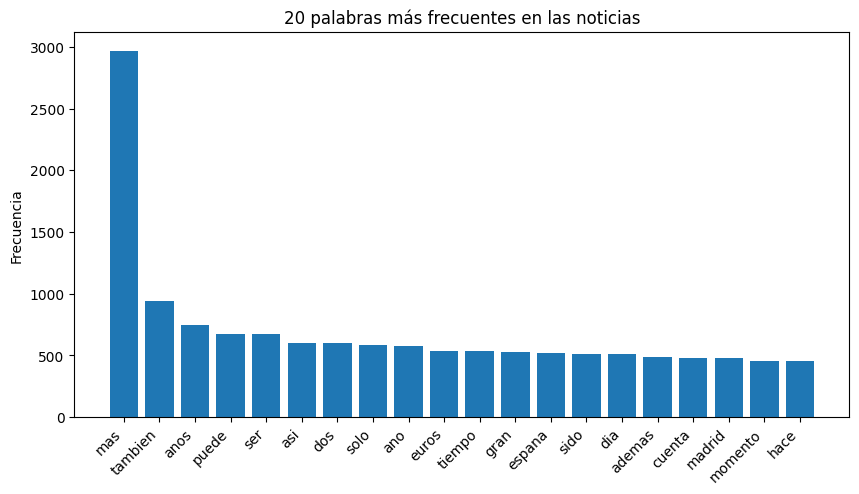

In [13]:
# Grafico de frecuencia de palabras
# Gráfico de las 20 palabras más frecuentes
plt.figure(figsize=(10,5))
plt.bar(freq_df['word'].head(20), freq_df['freq'].head(20))
plt.xticks(rotation=45, ha='right')
plt.title("20 palabras más frecuentes en las noticias")
plt.ylabel("Frecuencia")
plt.show()

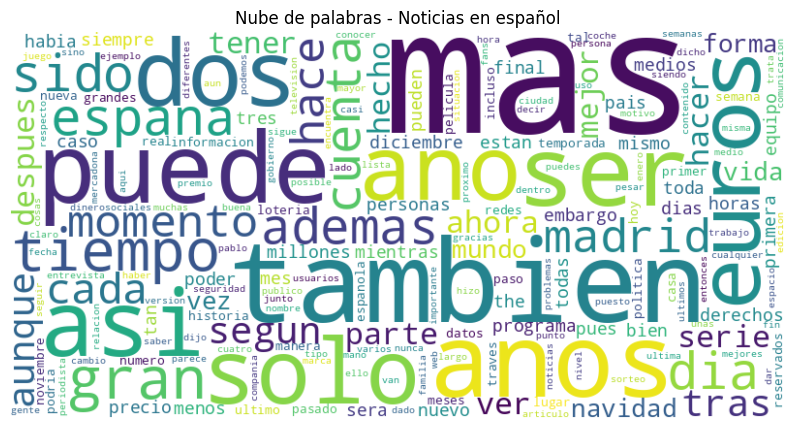

In [14]:
# Visualización de frecuencias (Nube de palabras)
# Generar la nube
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(freq_df.set_index('word')['freq'])

# Mostrar la nube
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Noticias en español")
plt.show()

## Matriz de presencia de término por documento

In [15]:
# Cuántos noticias contienen cada palabra
doc_freq = np.sum(X > 0, axis=0).A1  # .A1 convierte a array plano
doc_percentage = 100 * doc_freq / X.shape[0]

df_docfreq = pd.DataFrame({
    "word": terms,
    "n_docs": doc_freq,
    "pct_docs": doc_percentage
}).sort_values(by="pct_docs", ascending=False)

df_docfreq


,word,n_docs,pct_docs
1038,mas,712,83.764706
1674,tambien,473,55.647059
1596,ser,367,43.176471
144,asi,353,41.529412
97,anos,350,41.176471
...,...,...,...
1841,york,17,2.000000
1839,width,17,2.000000
1843,zaragoza,17,2.000000
0,abierta,17,2.000000


In [16]:
# Cantidad de palabras que aparece en cada noticia y sus porcentajes
freq_table = pd.Series(doc_freq).value_counts().reset_index()
freq_table.columns = ['Num_Noticia', 'Num_Palabras']
# Ordena el DataFrame por la cantidad de noticia
freq_table = freq_table.sort_values(by='Num_Noticia')
freq_table['Porcentaje_aparicion'] = (
    freq_table['Num_Palabras'] / freq_table['Num_Palabras'].sum() * 100
).round(2)

# Muestra el resultado
freq_table

,Num_Noticia,Num_Palabras,Porcentaje_aparicion
0,17,118,6.39
1,18,110,5.96
3,19,89,4.82
2,20,97,5.25
4,21,74,4.01
...,...,...,...
116,350,1,0.05
115,353,1,0.05
158,367,1,0.05
167,473,1,0.05


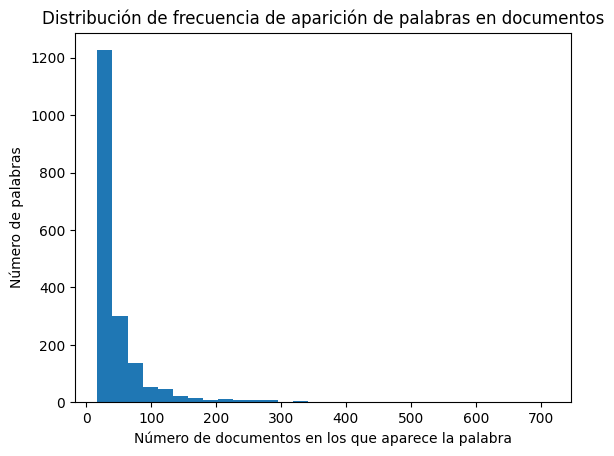

In [17]:
plt.hist(doc_freq, bins=30)
plt.title("Distribución de frecuencia de aparición de palabras en documentos")
plt.xlabel("Número de documentos en los que aparece la palabra")
plt.ylabel("Número de palabras")
plt.show()

## Asociaciones de palabras y graficos de correlacion

In [18]:
freq_threshold = 100  # aparece en más de 100 artículos, filtrar palabras muy poco frecuentes para acelerar el cálculo
dtm_filtrada = dt_matrix.loc[:, dt_matrix.sum(axis=0) > freq_threshold]

# Calcular matriz de correlación
c = dtm_filtrada.corr()

# Eliminar correlaciones débiles (<0.2)
corThreshold = 0.2
c[c < corThreshold] = 0

# Limpiar valores nulos y diagonales
c = np.nan_to_num(c)
np.fill_diagonal(c, 0)

# Ejemplo
palabra = "gobierno"
correlaciones = dtm_filtrada.corrwith(dtm_filtrada[palabra]).sort_values(ascending=False)
correlaciones.head(10)

,0
gobierno,1.000000
sanchez,0.478505
publico,0.229081
falta,0.194526
articulo,0.187248
acuerdo,0.180091
final,0.166504
explica,0.165659
tras,0.162883
medida,0.162291


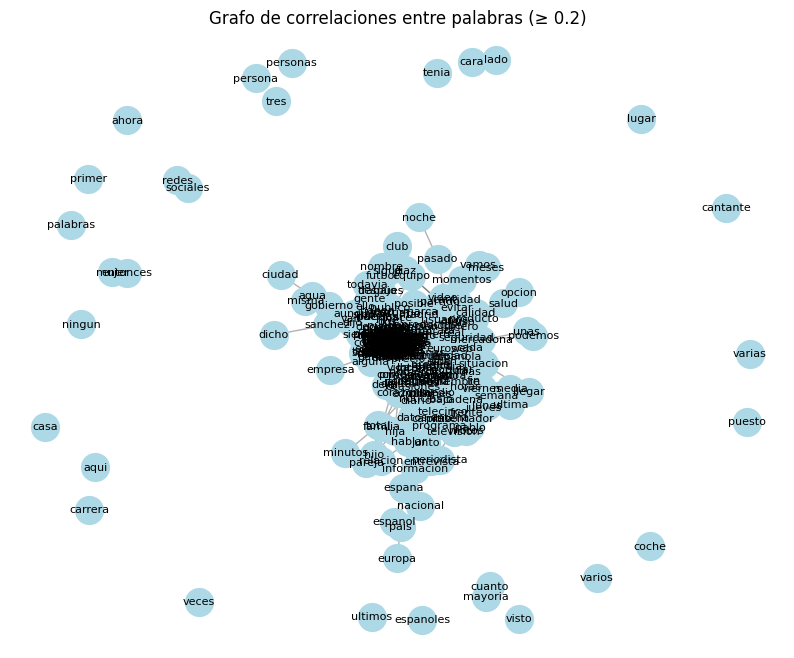

In [19]:
# Crear grafo no dirigido ponderado
G = nx.Graph(c)

# Etiquetas = nombres de las palabras
labels = {i: col for i, col in enumerate(dtm_filtrada.columns)}

# Dibujo del grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.title("Grafo de correlaciones entre palabras (≥ 0.2)")
plt.axis("off")
plt.show()

# Analisis cuantitativo de texto

In [20]:
# Longitud de palabras y número de palabras por noticia
# Número de palabras por noticia (después del preprocesado)
# Convierte el DataFrame dtm en una matriz
dtm_matrix = dt_matrix.values
# Obtiene los nombres de las columnas
column_names = dt_matrix.columns

# Filtra los nombres de las columnas para mantener solo aquellos con longitud menor a 20 caracteres (por errores en la lematización hay algunas palabras muy largas)
words = [name for name in column_names if len(name) < 20]

# Calcula las longitudes de las palabras y crea un DataFrame
word_lengths = pd.DataFrame({'Word': words, 'Length': [len(word) for word in words]})
# Obtén un resumen estadístico de las longitudes
summary = word_lengths['Length'].describe()
summary

,Length
count,1844.000000
mean,6.969631
std,2.235498
min,3.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,15.000000


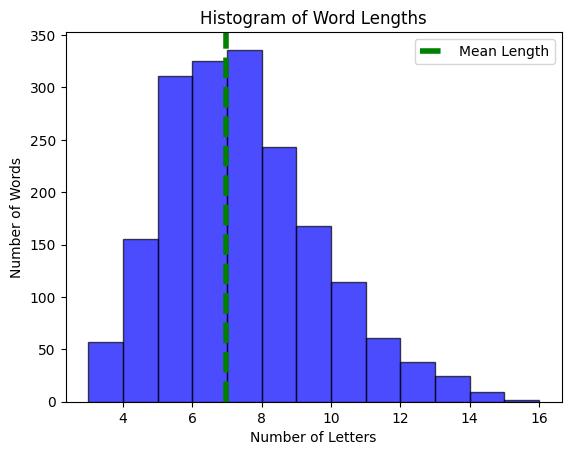

In [21]:
# Calcula la longitud de cada palabra en la lista
nletters = [len(word) for word in words]

# Crea un histograma de las longitudes de las palabras
plt.hist(nletters, bins=range(min(nletters), max(nletters) + 2), alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=sum(nletters) / len(nletters), color='green', linestyle='--', linewidth=4)

# Configura etiquetas y título
plt.xlabel('Number of Letters')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Lengths')
plt.legend(['Mean Length'])

plt.show()

In [22]:
# Frecuencia de letras
texto_total = " ".join(df["clean_text"])
words = texto_total.split()
# Divide las palabras en caracteres individuales
word_chars = [list(word) for word in words]

# Une todos los caracteres en una lista plana
flat_chars = [char for sublist in word_chars for char in sublist]
# Esto elimina números, guiones, barras bajas, símbolos y emojis, dejando solo letras válidas
# flat_chars = [char.lower() for sublist in word_chars for char in sublist if re.match(r'[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]', char)]

# Crea una tabla de frecuencia de las letras
dist_tab = pd.Series(flat_chars).value_counts().reset_index()
dist_tab.columns = ['Letter', 'Freq']

# Convierte la columna 'Letter' a mayúsculas y crea un factor
dist_tab['Letter'] = dist_tab['Letter'].str.upper()
dist_tab['Letter'] = pd.Categorical(dist_tab['Letter'],
                                    categories=dist_tab['Letter'].value_counts().index)

# Calcula la proporción de cada letra
dist_tab['Percent'] = dist_tab['Freq'] / dist_tab['Freq'].sum() * 100
dist_tab[:5]


print(dist_tab['Letter'])


0     A
1     E
2     O
3     I
4     R
5     S
6     N
7     T
8     C
9     D
10    L
11    M
12    U
13    P
14    B
15    G
16    V
17    F
18    H
19    J
20    Z
21    Y
22    Q
23    X
24    K
25    W
26    _
27    3
28    C
Name: Letter, dtype: category
Categories (28, object): ['C', 'A', 'O', 'E', ..., 'K', 'W', '_', '3']


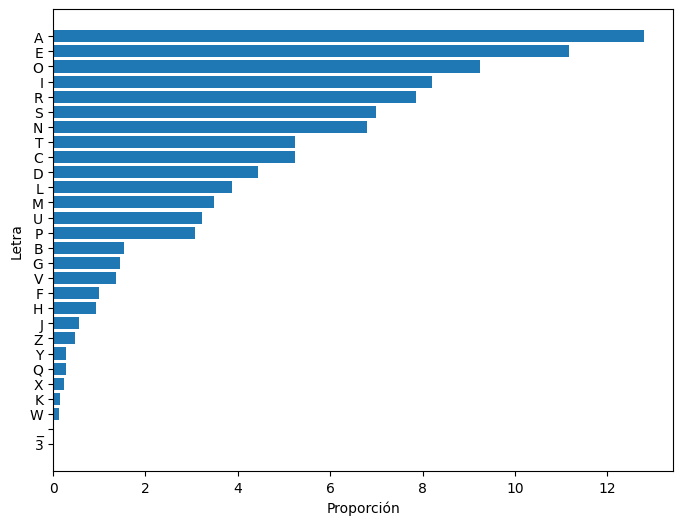

In [23]:
# Crea un gráfico de barras
plt.figure(figsize=(8, 6))
plt.barh(dist_tab['Letter'], dist_tab['Percent'])
plt.xlabel('Proporción')
plt.ylabel('Letra')
plt.gca().invert_yaxis()  # Invierte el eje y para que las letras se muestren en orden descendente
plt.show()

Aparece `3` y `_`, esto se puede deber a que hay palabras como covid_19 o 3D, y las están contando como letras. Pero si no quieres que aparezcan puedes usar la alternativa de flat_chars.

In [24]:
# Riqueza lexica, variedad de vocabulario
df['riqueza_lexica'] = df['clean_text'].apply(lambda x: len(set(x.split())) / len(x.split()))
df['riqueza_lexica'].describe()

,riqueza_lexica
count,850.000000
mean,0.734218
std,0.130328
min,0.075395
25%,0.699487
50%,0.760915
75%,0.812601
max,0.961039


# Cluster de similaridad

## Cluster de terminos

In [25]:
# Elegimos la DTM filtrada y un subconjunto de términos (para que el gráfico sea legible)
DTM = dtm_filtrada

min_total = 150   # frecuencia total mínima del término en el corpus
max_terms = 60     # máximo nº de términos a mostrar en el dendrograma

DTM_sub = DTM.loc[:, (DTM.sum(axis=0) >= min_total)]

top = DTM_sub.sum(axis=0).sort_values(ascending=False).head(max_terms).index
DTM_sub = DTM_sub.loc[:, top]

DTM_sub

# Para hacer el clustering por términos, debemos tenerlos en las filas, no las columnas, y extraer solo los valores en una matriz, no un data frame
X_terms = DTM_sub.T.values   # filas= términos, columnas= documentos
labels  = DTM_sub.columns    # nombres de los términos, lo guardamos para el gráfico

X_terms

array([[1, 1, 1, ..., 3, 0, 9],
       [2, 1, 1, ..., 1, 0, 3],
       [1, 3, 0, ..., 4, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 7]])

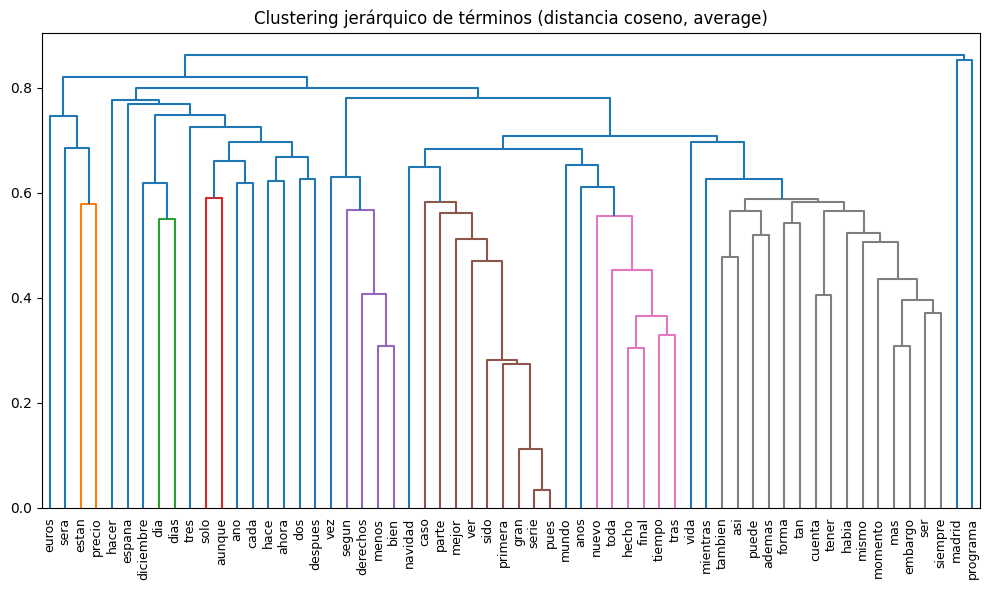

In [26]:
D = pdist(X_terms, metric='cosine')   # Usamos como distancia 1 - similitud de coseno (existen muchas otras opciones)
Z = linkage(D, method='average')      # Usamos un linkage o enlace average, habitual con la distancia del coseno

# Realizamos el gráfico con el dendograma, el gráfico que visualiza clusters jerárquicos
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=9, color_threshold=None)
plt.title("Clustering jerárquico de términos (distancia coseno, average)")
plt.tight_layout()
plt.show()

## Cluster por noticias

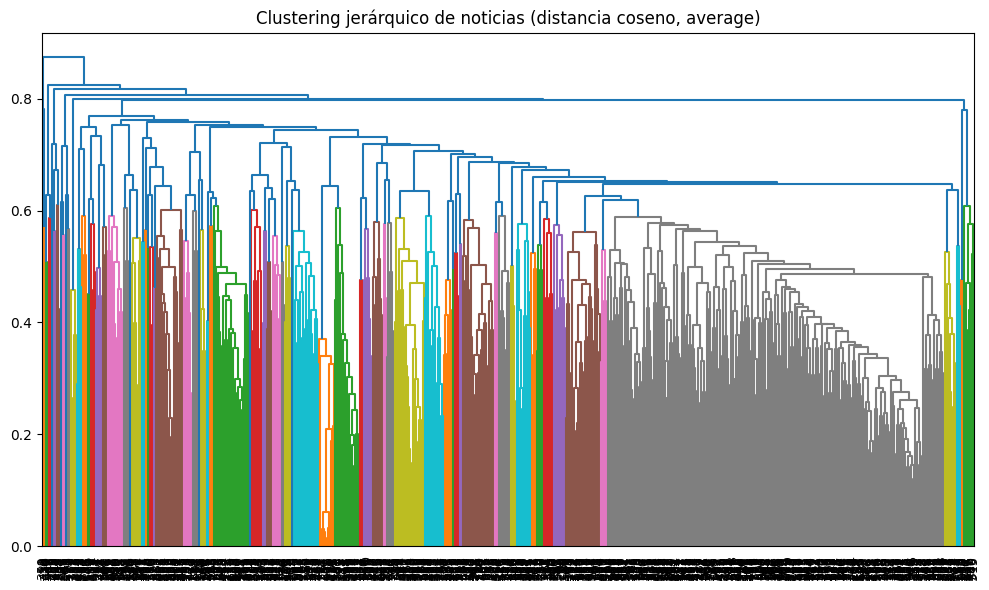

In [27]:
# En este caso queremos los documentos en las filas, y los términos en las columnas
X_terms_docs = DTM_sub.values

# Remove rows with all zeros to avoid issues with cosine distance
X_terms_docs = X_terms_docs[~np.all(X_terms_docs == 0, axis=1)]

D = pdist(X_terms_docs, metric='cosine')
Z = linkage(D, method='average')

plt.figure(figsize=(10, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=9, color_threshold=None)
plt.title("Clustering jerárquico de noticias (distancia coseno, average)")
plt.tight_layout()
plt.show()

Número de noticias por cluster:
29    461
27     45
20     39
24     37
17     33
23     31
21     29
26     20
14     17
18     14
13     14
25     12
12     11
28     10
31     10
11      7
19      7
4       7
8       6
3       6
10      6
6       5
7       4
9       4
15      3
22      3
1       2
16      2
30      2
5       1
2       1
Name: count, dtype: int64

Cluster 1 (n=2)
Ejemplos de noticias:
['alberto chicote junto equipo programa lasexta vas comer instalaciones fabrica productos supuestamente artesanos pedir explicaciones chef habia probado unas galletas empanada tarta podido comprobar realmente artesanales prometia empresa trabajadores habian asegurado equipo productos artesanales embargo pudieron comprobar contenian conservantes ingredientes delataba equipo llego poligono encontraba fabrica rapidamente invitaron chicote entrar conocemos television decia trabajadores embargo buenas caras esfumaron pronto chicote decidio directo grano pregunta artesanal responsables tratar

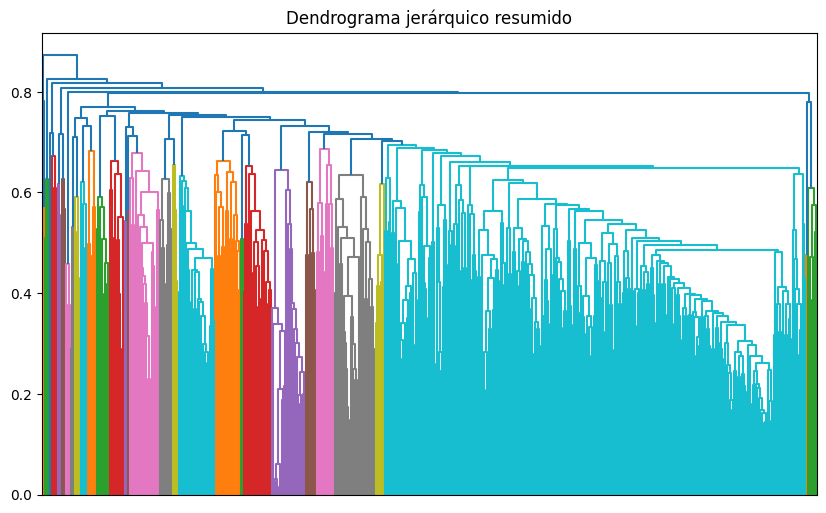

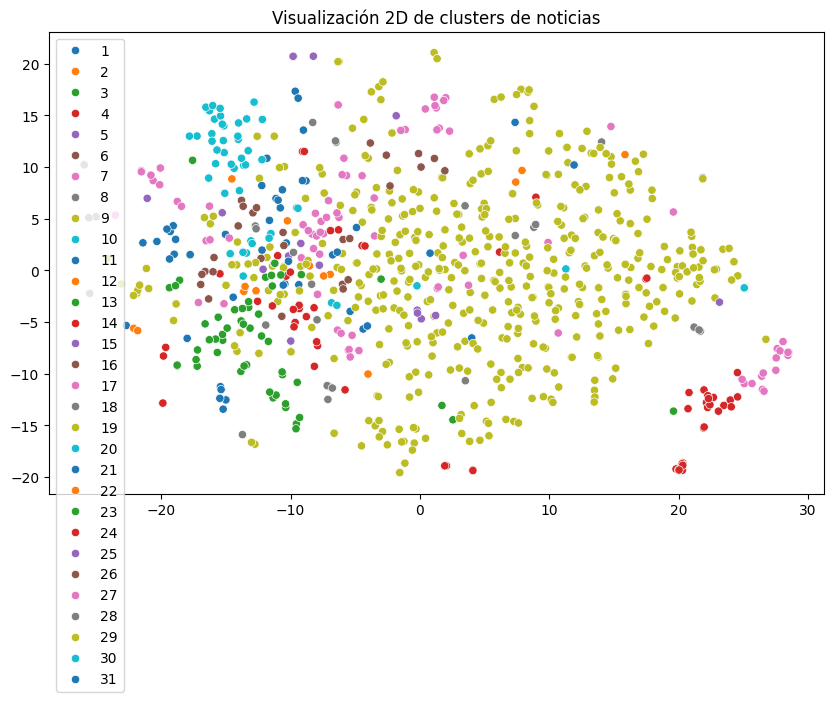

In [28]:
# Select the rows from df that correspond to the non-zero rows in X_terms_docs
df_filtered = df[~np.all(DTM_sub.values == 0, axis=1)].copy()

# Filter dtm_filtrada based on the same rows
dtm_filtrada = dtm_filtrada.loc[df_filtered.index, :].copy()

# Cortar dendrograma para asignar clusters
treshold = 0.7  # Ajusta según cuántos clusters quieras
clusters = fcluster(Z, t=treshold, criterion='distance')

# Add cluster assignments to both dataframes
dtm_filtrada['cluster'] = clusters
df_filtered['cluster'] = clusters


# Resumen de clusters
print("Número de noticias por cluster:")
print(pd.Series(clusters).value_counts())

for c in sorted(dtm_filtrada['cluster'].unique()):
    print(f"\nCluster {c} (n={sum(dtm_filtrada['cluster']==c)})")
    print("Ejemplos de noticias:")
    print(df_filtered[df_filtered['cluster']==c]['clean_text'].head(3).tolist())

# Opcional: dendrograma resumido mostrando solo cluster principales
plt.figure(figsize=(10,6))
dendrogram(Z, no_labels=True, color_threshold=treshold)
plt.title("Dendrograma jerárquico resumido")
plt.show()

# t-SNE para visualización 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_terms_docs)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=clusters, palette='tab10', legend='full')
plt.title("Visualización 2D de clusters de noticias")
plt.show()

# Análisis de clasificación Temática

In [29]:
# --- 1. PREPARACIÓN DE DATOS ADAPTADA ---

# La 'X' de entrada es el texto preprocesado.
X = df_filtered["clean_text"]
# La 'y' de salida es la etiqueta de Cluster (la convertimos a string si es necesario).
y = df_filtered["cluster"].astype(str)

# --- 2. DIVISIÓN DE DATOS ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- 3. CREACIÓN Y ENTRENAMIENTO del Pipeline ---

clf = make_pipeline(
    TfidfVectorizer(strip_accents="unicode", lowercase=True, ngram_range=(1,2), min_df=1),
    LinearSVC(random_state=42)
)

print("Entrenando clasificador...")
clf.fit(X_train, y_train)

# --- 4. EVALUACIÓN DEL MODELO ---
y_pred = clf.predict(X_test)

print("\n" + "="*50)
print("INFORME DE CLASIFICACIÓN TEMÁTICA (Clusters)")
print("="*50)
# Esto evalúa qué tan bien el modelo predice la categoría temática (cluster) de una noticia.
print(classification_report(y_test, y_pred))

# --- 5. EXTRACCIÓN DE RASGOS (Términos Clave por Cluster) ---
# Se adapta la extracción de rasgos para ver qué términos son más importantes para cada uno de tus clusters temáticos.

vec = clf.named_steps["tfidfvectorizer"]
svc = clf.named_steps["linearsvc"]
feats = vec.get_feature_names_out()

print("\n" + "="*50)
print("TOP RASGOS CARACTERÍSTICOS POR CLUSTER")
print("="*50)

# Iterar sobre las clases (clusters) predichas
for i, cluster_label in enumerate(svc.classes_):
    # El coeficiente para el cluster 'cluster_label'
    coefs = svc.coef_[i]

    # Ordenar los coeficientes para encontrar los rasgos más predictivos (positivos)
    # del cluster específico (los que más "empujan" una noticia a ser clasificada como Cluster X)
    top_terms = pd.Series(coefs, index=feats).sort_values(ascending=False).head(10)

    print(f"\nCluster {cluster_label} (Top 10 Rasgos Típicos):")
    # Los términos con coeficientes más altos son los más distintivos de ese cluster.
    print(top_terms)

Entrenando clasificador...

INFORME DE CLASIFICACIÓN TEMÁTICA (Clusters)
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         1
          17       1.00      0.14      0.25         7
          18       0.00      0.00      0.00         3
          19       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         1
          20       1.00      0.30      0.46        10
          21       0.00      0.00      0.00         9
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00        13
          24       1.00      0.40      0.57        15
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



TOP RASGOS CARACTERÍSTICOS POR CLUSTER

Cluster 10 (Top 10 Rasgos Típicos):
gallegos         0.391876
prefijo          0.383540
espanoles        0.314327
kamiya           0.310129
xiaomi           0.302234
piensan          0.300311
juegos           0.263137
platinumgames    0.247784
hideki kamiya    0.247784
hideki           0.247784
dtype: float64

Cluster 11 (Top 10 Rasgos Típicos):
cartel       0.350212
jugador      0.291201
dias         0.242470
sentencia    0.213106
buenos       0.210229
falso        0.203704
mercadona    0.202055
club         0.185278
fifa         0.174592
despido      0.174414
dtype: float64

Cluster 12 (Top 10 Rasgos Típicos):
sarten               0.506608
uva                  0.449417
declaracion          0.392424
caso                 0.364493
tuvalu               0.355254
alcoholemia          0.309986
declaracion anual    0.291101
oscar                0.273864
esther               0.266686
canales              0.264701
dtype: float64

Cluster 13 (Top 10 Rasg

# Análisis Descriptivo por Fuente (web_url)

In [30]:
# Función para extraer el dominio principal de una URL
def extract_domain(url):
    try:
        # Usa urlparse para descomponer la URL
        domain = urlparse(url).netloc
        # Eliminar 'www.' si existe y asegurarse de que solo se queda el dominio principal
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'UNKNOWN'

# Creamos la nueva columna 'source'
df_filtered['source'] = df_filtered['web_url'].apply(extract_domain)

# Contar cuántas noticias tienes por fuente para ver los medios principales
print("Top 10 Medios de Comunicación en el Dataset:")
print(df_filtered['source'].value_counts().head(10))

Top 10 Medios de Comunicación en el Dataset:
source
huffingtonpost.es                 156
okdiario.com                       61
cope.es                            56
cadenaser.com                      39
ow.ly                              35
mundodeportivo.com                 33
buff.ly                            21
lectur.as                          20
eltelevisero.huffingtonpost.es     18
bit.ly                             17
Name: count, dtype: int64


## Longitud Media del Texto: ¿Las noticias de un medio son sistemáticamente más largas o más cortas?

In [31]:
# Calcula la longitud del texto (web_text)
df_filtered['text_length'] = df_filtered['web_text'].apply(len)
# Compara la media por fuente
print("\nLongitud Media del Texto por Fuente (Top 5):")
print(df_filtered.groupby('source')['text_length'].mean().sort_values(ascending=False).head(5))


Longitud Media del Texto por Fuente (Top 5):
source
alfabetajuega.com            29007.2
elpais.com                   10956.0
lawebdelinformatico.es        8607.0
nationalgeographic.com.es     8525.0
cnn.it                        7008.5
Name: text_length, dtype: float64


## Distribución de Clusters: ¿Ciertos medios se enfocan más en temas específicos?

In [32]:
# Tabla de contingencia de Cluster vs. Fuente
cluster_source_pivot = pd.crosstab(df_filtered['cluster'], df_filtered['source'], normalize='columns')
print("\nDistribución de Clusters por Fuente (Primeras 3 fuentes y clusters):")
print(cluster_source_pivot.head(20).iloc[:, :20])


Distribución de Clusters por Fuente (Primeras 3 fuentes y clusters):
source   20minutos.es  3djuegos.com  abc.com.py  adslzone.net  \
cluster                                                         
1                 0.0      0.000000         0.0      0.000000   
2                 0.0      0.000000         0.0      0.000000   
3                 0.0      0.000000         0.0      0.000000   
4                 0.0      0.000000         0.0      0.000000   
5                 0.0      0.000000         0.0      0.000000   
6                 0.0      0.000000         0.0      0.000000   
7                 0.0      0.000000         0.0      0.000000   
8                 0.0      0.000000         0.0      0.000000   
9                 0.0      0.000000         0.0      0.000000   
10                0.0      0.000000         0.0      0.000000   
11                0.0      0.000000         0.0      0.000000   
12                0.0      0.000000         0.0      0.111111   
13                0.

# Análisis de Sentimiento con Librería Externa
Para el análisis de sentimiento en español sin un corpus etiquetado, la mejor estrategia es usar una librería pre-entrenada para español. La librería sentiment-analysis-spanish (o su versión más moderna pysentimiento) es una excelente opción. pysentimiento suele ofrecer modelos más robustos basados en Transformers (BERT-like) y no solo analiza sentimiento (positivo, negativo, neutral), sino también emociones (alegría, tristeza, etc.).

In [33]:
# Crear el analizador para la tarea de SENTIMIENTO en español
# 'sentiment' etiqueta: POSITIVE, NEGATIVE, NEUTRAL
sentiment_analyzer = create_analyzer(task="sentiment", lang="es")

# Crear el analizador para la tarea de EMOCIÓN en español
emotion_analyzer = create_analyzer(task="emotion", lang="es")


# Aplicar el análisis al texto de la noticia (web_text)
def analyze_text_nlp(text, analyzer_type):
    """Function to apply Sentiment or Emotion analysis and return structured results."""
    if not isinstance(text, str) or not text.strip():
        # Return empty values if the text is not valid
        if analyzer_type == 'sentiment':
            return ['EMPTY', 0.0, 0.0, 0.0]
        elif analyzer_type == 'emotion':
             return ['EMPTY', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
             return []


    try:
        if analyzer_type == 'sentiment':
            analysis = sentiment_analyzer.predict(text)
            return [analysis.output, analysis.probas['POS'], analysis.probas['NEG'], analysis.probas['NEU']]

        elif analyzer_type == 'emotion':
            analysis = emotion_analyzer.predict(text)
            main_emotion = analysis.output
            return [main_emotion, analysis.probas.get('joy', 0.0), analysis.probas.get('sadness', 0.0),
                    analysis.probas.get('anger', 0.0), analysis.probas.get('fear', 0.0),
                    analysis.probas.get('surprise', 0.0), analysis.probas.get('disgust', 0.0), analysis.probas.get('other', 0.0)]
    except Exception as e:
        # In case of an error, return error values
        if analyzer_type == 'sentiment':
            return ['ERROR', 0.0, 0.0, 0.0]
        elif analyzer_type == 'emotion':
             return ['ERROR', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
             return []

# Apply analysis to the news text (web_text)
text_sentiment_results = df_filtered['web_text'].apply(lambda x: analyze_text_nlp(x, 'sentiment'))
text_emotion_results = df_filtered['web_text'].apply(lambda x: analyze_text_nlp(x, 'emotion'))

# Unpack the results into separate columns for news text
df_filtered[['text_sentiment', 'text_prob_pos', 'text_prob_neg', 'text_prob_neu']] = pd.DataFrame(text_sentiment_results.tolist(), index=df_filtered.index)
df_filtered[['text_emotion', 'text_prob_joy', 'text_prob_sad', 'text_prob_anger',
             'text_prob_fear', 'text_prob_surprise', 'text_prob_disgust', 'text_prob_other']] = pd.DataFrame(text_emotion_results.tolist(), index=df_filtered.index)


# Apply analysis to the headline (web_headline)
headline_sentiment_results = df_filtered['web_headline'].apply(lambda x: analyze_text_nlp(x, 'sentiment'))
headline_emotion_results = df_filtered['web_headline'].apply(lambda x: analyze_text_nlp(x, 'emotion'))

# Unpack the results into separate columns for headline
df_filtered[['headline_sentiment', 'headline_prob_pos', 'headline_prob_neg', 'headline_prob_neu']] = pd.DataFrame(headline_sentiment_results.tolist(), index=df_filtered.index)
df_filtered[['headline_emotion', 'headline_prob_joy', 'headline_prob_sad', 'headline_prob_anger',
             'headline_prob_fear', 'headline_prob_surprise', 'headline_prob_disgust', 'headline_prob_other']] = pd.DataFrame(headline_emotion_results.tolist(), index=df_filtered.index)

config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [34]:
# ANÁLISIS DESCRIPTIVO DE RESULTADOS

print("\n" + "="*70)
print("ANÁLISIS 1: DISTRIBUCIÓN DE SENTIMIENTO Y EMOCIÓN")
print("="*70)

print("\n--- SENTIMIENTO PREDOMINANTE EN EL TITULAR ---")
print(df_filtered['headline_sentiment'].value_counts(normalize=True))

print("\n--- SENTIMIENTO PREDOMINANTE EN EL CUERPO ---")
print(df_filtered['text_sentiment'].value_counts(normalize=True))

print("\n--- EMOCIÓN PREDOMINANTE EN EL TITULAR ---")
print(df_filtered['headline_emotion'].value_counts(normalize=True))



ANÁLISIS 1: DISTRIBUCIÓN DE SENTIMIENTO Y EMOCIÓN

--- SENTIMIENTO PREDOMINANTE EN EL TITULAR ---
headline_sentiment
NEU    0.448763
NEG    0.372203
POS    0.179034
Name: proportion, dtype: float64

--- SENTIMIENTO PREDOMINANTE EN EL CUERPO ---
text_sentiment
NEU    0.444052
POS    0.294464
NEG    0.261484
Name: proportion, dtype: float64

--- EMOCIÓN PREDOMINANTE EN EL TITULAR ---
headline_emotion
others      0.936396
joy         0.034158
surprise    0.011779
anger       0.010601
sadness     0.007067
Name: proportion, dtype: float64

ANÁLISIS 2: EL EFECTO CLICKBAIT (Comparación Titular vs. Cuerpo)


In [35]:
# -----------------------------------------------------------------------
print("\n" + "="*70)
print("ANÁLISIS 2: EL EFECTO CLICKBAIT (Comparación Titular vs. Cuerpo)")
print("="*70)

# El clickbait explota la diferencia entre la emoción del titular y la realidad del texto.

# 1. ¿Qué titular es más negativo que el cuerpo? (Falsa alarma o exageración)
df_filtered['diff_negativity'] = df_filtered['headline_prob_neg'] - df_filtered['text_prob_neg']

print("\n--- TOP 5 NOTICIAS CON MAYOR EXAGERACIÓN NEGATIVA EN EL TITULAR ---")
top_exaggeration = df_filtered.sort_values(by='diff_negativity', ascending=False).head(5)
for index, row in top_exaggeration.iterrows():
    print(f"Titular: {row['web_headline']}")
    print(f"Neg. Head: {row['headline_prob_neg']:.2f} | Neg. Text: {row['text_prob_neg']:.2f} | Diff: {row['diff_negativity']:.2f}")

# 2. ¿Qué emociones negativas son más frecuentes en los titulares?
print("\n--- MEDIAS DE PROBABILIDAD DE EMOCIONES NEGATIVAS EN TITULARES ---")
print(df_filtered[['headline_prob_anger', 'headline_prob_fear', 'headline_prob_disgust']].mean().sort_values(ascending=False))

# -----------------------------------------------------------------------
print("\n" + "="*70)
print("ANÁLISIS 3: DIFERENCIAS POR FUENTE DE NOTICIAS")
print("="*70)

# Agrupamos por fuente para ver si hay un "estilo emocional" por medio
source_emotion_analysis = df_filtered.groupby('source').agg(
    Avg_Neg_Head=('headline_prob_neg', 'mean'),
    Avg_Anger_Head=('headline_prob_anger', 'mean'),
    Total_Articles=('web_url', 'count')
).sort_values(by='Avg_Neg_Head', ascending=False)

print("\n--- RANKING DE FUENTES POR NEGATIVIDAD MEDIA EN EL TITULAR ---")
print(source_emotion_analysis.head(5))

# Distribución de la emoción principal del titular por fuente (tabla de contingencia)
source_emotion_pivot = pd.crosstab(df_filtered['headline_emotion'], df_filtered['source'], normalize='columns')
print("\n--- DISTRIBUCIÓN DE EMOCIONES DEL TITULAR POR FUENTE (TOP 3) ---")
print(source_emotion_pivot.head(3).iloc[:, :5])


--- TOP 5 NOTICIAS CON MAYOR EXAGERACIÓN NEGATIVA EN EL TITULAR ---
Titular: Se fija en lo que está pasando en los sitios de playa con los turistas y se indigna: da para reflexión
Neg. Head: 0.96 | Neg. Text: 0.03 | Diff: 0.93
Titular: No dan crédito a lo que se vio en el metro de Nueva York
Neg. Head: 0.94 | Neg. Text: 0.01 | Diff: 0.93
Titular: Ayuso acude a un acto del PP en Castilla-La Mancha y muchos no dan crédito a lo primero que dice
Neg. Head: 0.93 | Neg. Text: 0.01 | Diff: 0.92
Titular: Jorge Javier Vázquez habla claro en 'Sálvame' de su peor recuerdo del instituto: "De mis mayores depresiones" - Televisión - COPE
Neg. Head: 0.95 | Neg. Text: 0.04 | Diff: 0.91
Titular: Karlos Arguiñano se salta el guion y manda un claro mensaje a la receta de Garzón: "Me preocupa" - Televisión - COPE
Neg. Head: 0.91 | Neg. Text: 0.01 | Diff: 0.91

--- MEDIAS DE PROBABILIDAD DE EMOCIONES NEGATIVAS EN TITULARES ---
headline_prob_anger      0.012994
headline_prob_fear       0.006487
headline_pr

# Exportación del notebook


In [36]:
# Celda para compilar el notebook a HTML (descomentar la siguiente línea, hace falta tener instalado nbconvert)
# Una vez creado el HTML, podemos abrirlo en el navegador web y con ctrl+print guardarlo como PDF
# !jupyter nbconvert --to html "2_text_mining.ipynb"